In [3]:
import folium
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import squarify 
import pandas as pd
from matplotlib.sankey import Sankey
import seaborn as sns
import time

In [4]:
def load_census_data(directory):
    # Load census data from given directory
    df = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.csv'):
            df_temp = pd.read_csv(os.path.join(directory,filename),skiprows=1)
            df_temp["Year_ID"] = filename[:4] + df_temp['Id2'].map(str)
            df_temp = df_temp.set_index("Year_ID")
            df.append(df_temp)


    census_data = pd.concat(df)
    return census_data
def load_drug_data():
    
    census_data = load_census_data("data/census_data_2013/")
    
    drug_data = pd.read_excel('data/drug_data.xlsx', sheet_name = "Data")
   # drug_data = drug_data[drug_data["YYYY"] >= 2013]
    drug_data["Year_ID"] = drug_data["YYYY"].map(str) + drug_data["FIPS_Combined"].map(str)
    drug_data = drug_data.set_index("Year_ID")
    fips = drug_data["FIPS_Combined"].map(str).apply(lambda x: x[2:])[~drug_data.index.duplicated()]
    state = drug_data[["State","YYYY","COUNTY"]][~drug_data.index.duplicated()]
    
    drug_piv = drug_data.pivot(columns="SubstanceName", values=["DrugReports"])

    drug_piv[["TotalDrugReportsCounty","TotalDrugReportsState"]] = drug_data.drop_duplicates(subset=["TotalDrugReportsCounty","TotalDrugReportsState"])[["TotalDrugReportsCounty","TotalDrugReportsState"]]
    
    drug_piv["Total"] = drug_piv["DrugReports"].sum(axis=1).fillna(0)
    drug_piv["FIPS"] = fips
    drug_piv[["State","Year","Name"]] = state
    drug_piv["DrugReportsPerCapita"] = drug_piv["Total"]/census_data["Estimate; RELATIONSHIP - Population in households"]
    return drug_piv


In [5]:
drug_data = load_drug_data()

/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [6]:
#drug_data.groupby(["State","Year","FIPS"]["TotalDrugReportsCounty"].nlargest(3).groupby("State"))

In [7]:
street_drugs = ['Opium', 'Opiates', 'Acetylcodeine']

fentanyl = ['Fentanyl', 'Acetyl fentanyl', 'Butyryl fentanyl',
       'Furanyl fentanyl', 'p-Fluorobutyryl fentanyl', 'cis-3-methylfentanyl',
       'Valeryl fentanyl', 'Carfentanil', 'Acryl fentanyl', 'U-47700',
       '3-Methylfentanyl', '4-Fluoroisobutyryl fentanyl',
       'trans-3-Methylfentanyl', 'p-methoxybutyryl fentanyl',
       'Tetrahydrofuran fentanyl', 'p-Fluorofentanyl', 'o-Fluorofentanyl',
       '3-Fluorofentanyl', 'Fluorofentanyl', 'Fluoroisobutyryl fentanyl',
       'Fluorobutyryl fentanyl ', 'Furanyl/3-Furanyl fentanyl',
       'Cyclopropyl fentanyl', 'Methoxyacetyl fentanyl', 'Phenyl fentanyl',
       'Benzylfentanyl', 'U-48800', 'U-49900', 'Crotonyl fentanyl',
       '3,4-Methylenedioxy U-47700', 'U-51754',
       'Cyclopropyl/Crotonyl Fentanyl', 'Isobutyryl fentanyl',
       'Cyclopentyl fentanyl', '4-Methylfentanyl'] 

prescription = ['Propoxyphene', 'Morphine', 'Methadone', 'Hydromorphone', 'Oxycodone',
 'Oxymorphone', 'Dextropropoxyphene', 'Buprenorphine', 'Hydrocodone', 'Meperidine',
 'Methorphan', 'Codeine', 'Tramadol', 'Pethidine', 'Dihydrocodeine',
 'Pentazocine','Thebaine', 'Butorphanol', 'ANPP',
 'Desmethylprodine ', 'Mitragynine', 'Acetyldihydrocodeine', 'Hydrocodeinone',
 'MT-45', 'Levorphanol', 'Metazocine']
HeroinData = drug_data.groupby(["State","Year"]).sum()["DrugReports"]['Heroin']
StreetDrugData = drug_data.groupby(["State","Year"]).sum()["DrugReports"][street_drugs].sum(axis=1)
FentanylData = drug_data.groupby(["State","Year"]).sum()["DrugReports"][fentanyl].sum(axis=1)
PrescriptionData = drug_data.groupby(["State","Year"]).sum()["DrugReports"][prescription].sum(axis=1)
frames = [HeroinData, StreetDrugData, FentanylData, PrescriptionData]
result = pd.concat(frames,axis=1)
result.rename(columns={0:'Other',1:'Fentanyls',2:'Prescription'},inplace=True)
#result

In [8]:
%matplotlib inline
#inputs:
#state="OH",ect.
#year=2013-2017
def CreatePieChart(state,year,):
    if (state == 'KY'):
        STATE = 'Kentucky'
    elif (state == 'OH'):
        STATE = "Ohio"
    elif (state == 'PA'):
        STATE = "Pennsylvania"
    elif (state == 'VA'):
        STATE = "Virginia"
    elif (state == "WV"):
        STATE = "West Virginia"
    else:
        STATE = "AllStates"
        
        
    if (state=="AllStates"):
        data = [int(drugsbydata.groupby("Year").sum()["Heroin"].loc[year]),int(drugsbydata.groupby("Year").sum()["Fentanyl"].loc[year]),int(drugsbydata.groupby("Year").sum()["Prescription"].loc[year]),int(drugsbydata.groupby("Year").sum()["Other"].loc[year])]
        wedges, texts, autotexts = plt.pie(data,
                        colors=["#c1dbb3","#ffc971","#6F8AB7","#32292F"],
                     radius=2.5,
                     autopct = lambda pct: "{0}".format(int(pct/100*np.sum(data))),
                     )
    else:
        data = [int(result.Heroin[state,year,]),int(result.Fentanyls[state,year,]),int(result.Prescription[state,year]),int(result.Other[state,year])]
        wedges, texts, autotexts = plt.pie(data,
                        colors=["#c1dbb3","#ffc971","#6F8AB7","#32292F"],
                     radius=2.5,
                     autopct = lambda pct: "{0}".format(int(pct/100*np.sum(data))),
                     )

    plt.legend(['Heroin','Fentanyls','Prescription','Other'],loc='upper right', bbox_to_anchor=(2.0, 1.55,0,0), fontsize='x-large'
    )
    if (state == "AllStates"):
        plt.title('Total Opoiod Drug Reports\u2014'+str(year), fontdict = {'fontsize': 30, 'verticalalignment':'top'}, pad=150)
    else:
        plt.title('Reports by Drug in '+STATE+'\u2014'+str(year), fontdict = {'fontsize': 30, 'verticalalignment':'top'}, pad=150)
    plt.setp(autotexts, size=16, weight='bold')
    
    
    filename = f"{state}_DrugPieChart_{year}"
    plt.savefig(filename+'.png', bbox_inches='tight')
    plt.show()
    
#CreatePieChart(state='AllStates',year=2017)

In [ ]:
drugsbydata.groupby("Year").sum()["Heroin"].loc[2016]

In [ ]:
drug_data.head()

In [9]:
drugsbydata = pd.concat([drug_data["FIPS"], drug_data["Name"], drug_data["DrugReports"]["Heroin"], drug_data["State"],drug_data["Year"], drug_data["DrugReports"][fentanyl].sum(axis=1), drug_data["DrugReports"][prescription].sum(axis=1),drug_data["DrugReports"][street_drugs].sum(axis=1),drug_data["DrugReports"]["Buprenorphine"],drug_data["Total"]],axis=1)
drugsbydata.rename(columns={0:'Fentanyl',1:'Prescription',2:'Other'},inplace=True)
census_data = load_census_data("data/census_data_2013/")
drugsbydata["BuprenorphineLogged"] = np.log(drugsbydata["Buprenorphine"])
drugsbydata["HeroinLogged"] = np.log(drugsbydata["Heroin"])
drugsbydata["FentanylLogged"] = np.log(drugsbydata["Fentanyl"])
drugsbydata["PrescriptionLogged"] = np.log(drugsbydata["Prescription"])
drugsbydata["OtherLogged"] = np.log(drugsbydata["Other"])
drugsbydata["TotalLogged"] = np.log(drugsbydata["Total"])
drugsbydata["HeroinPC"] = drugsbydata["Heroin"]/census_data["Estimate; RELATIONSHIP - Population in households"]
drugsbydata["FentanylPC"] = drugsbydata["Fentanyl"]/census_data["Estimate; RELATIONSHIP - Population in households"]
drugsbydata["PrescriptionPC"] = drugsbydata["Prescription"]/census_data["Estimate; RELATIONSHIP - Population in households"]
drugsbydata["OtherPC"] = drugsbydata["Other"]/census_data["Estimate; RELATIONSHIP - Population in households"]
drugsbydata["BuprenorphinePC"] = drugsbydata["Buprenorphine"]/census_data["Estimate; RELATIONSHIP - Population in households"]
drugsbydata = drugsbydata.fillna(0)
drugsbydata = drugsbydata.replace([np.inf, -np.inf], 0)
#drugsbydata

/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]
/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [170]:
#Custom Color function for KMeans data
def ColorFunction(feature):
    if feature == 1:
        return '#ff0000'
    elif feature == 2:
        return '#008000'
    elif feature == 3:
        return '#008000'
    elif feature == 4:
        return '#008000'
    elif feature == 5:
        return '#008000'
    elif feature == 6:
        return '#008000'
    else:
        return '#000000'

#Inputs:
#state='KY','WV','OH','VA', or 'PA'
#year=2013,2014,2015, or 2016
#Type='Total','DrugReportsPerCapita'
#filename='example.html'
#Data=Pandas data frame
#column2=
def CreateStateMap(state,year,Type,Data):
    #Sets Topojson and coordinates for inputted state
    if (state == "KY"):
        STATE = os.path.join('data', 'KY-21-kentucky-counties.json')
        TOPOS = 'objects.cb_2015_kentucky_county_20m'
        Cords = [37.494283, -85.445286]
    elif (state == "WV"):
        STATE = os.path.join('data', 'WV-54-west-virginia-counties.json')
        TOPOS = 'objects.cb_2015_west_virginia_county_20m'
        Cords = [38.90, -80.95]
    elif (state == "OH"):
        STATE = os.path.join('data', 'OH-39-ohio-counties.json')
        TOPOS = 'objects.cb_2015_ohio_county_20m'
        Cords = [40.25, -82.50]
    elif (state == "VA"):
        STATE = os.path.join('data', 'VA-51-virginia-counties.json')
        TOPOS = 'objects.cb_2015_virginia_county_20m'
        Cords = [37.728, -79.40]
    else:
        STATE = os.path.join('data', 'PA-42-pennsylvania-counties.json')
        TOPOS = 'objects.cb_2015_pennsylvania_county_20m'
        Cords = [40.81, -77.827679]

    #Create Map 
    M = folium.Map(
    location = Cords,
    zoom_start=8,
    tiles='cartodbpositron'
    )
    
    #Pull correct data
    Data = Data[(Data["State"]==state) & (Data["Year"]==year)]
    
    #Make threshold_scale
    Scaler = Data.loc[Data["State"]==state][Type].max()/5.95
    if (Scaler != 0):
        Scale = [0, Scaler, 2*Scaler, 3*Scaler, 4*Scaler, 5*Scaler, 6*Scaler]
    else:
        Scale = None
    
    #Make Legend
    if (Type=="DrugReportsPerCapita"):
        Legend=f"Total Opioid Drug Reports Per Capita\u2014{year}"
    elif (Type=="Total"):
        Legend=f"Total Opiod Drug Reports\u2014{year}"
    elif ("Logged" in Type and "Total" in Type):
        Legend= f"Log of Total Drug Reports\u2014{year}"
    elif ("Logged" in Type):
        temp = Type[:-6]
        Legend= "Log of Total "+temp+" Drug Reports\u2014"+str(year)
    else:
        Legend= f"Total {Type} Drug Reports\u2014{year}"
    
   
    #Detect map color
    if ("Heroin" in Type): color = 'BuGn'; nan = "#e5f5f9"
    elif ('Fentanyl' in Type): color = 'YlGn'; nan = "#f7fcb9"
    elif ( 'Prescription' in Type): color = 'PuBu'; nan = "#e0ecf4"
    elif ('Other' in Type): color = 'Purples'; nan = "#efedf5"
    else: color = 'OrRd'; nan ="#fee8c8"
        
    #Create layer
    folium.Choropleth(
        open(STATE),
        topojson = TOPOS,
        data=Data,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = color,
        nan_fill_color = nan,
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = Legend,
        threshold_scale= Scale,
        highlight = True
        ).add_to(M)
    
    #save file if wanted
    filename = f"{state}_{Type}_{year}"
    M.save(outfile=filename)

        
    #Output map
    #return M
        
#CreateStateMap(state='WV',year=2013,Type='FentanylPC',Data=drugsbydata)

In [171]:
#Inputs:
#year=2013,2014,2015, or 2016
#Type='Total','DrugReportsPerCapita'
#filename=''
def CreateAllStatesMap(year,Type,Data):
    #Sets Topojson and coordinates for states
    KENT = os.path.join('data', 'KY-21-kentucky-counties.json')
    WESTV = os.path.join('data', 'WV-54-west-virginia-counties.json')
    OHIO = os.path.join('data', 'OH-39-ohio-counties.json')
    VIRG = os.path.join('data', 'VA-51-virginia-counties.json')
    PENN = os.path.join('data', 'PA-42-pennsylvania-counties.json')

    #Create Map 
    M = folium.Map(
    location = [39.25,-80.82],
    zoom_start=7,
    tiles='cartodbpositron'
    )
    
    #Pull all state data
    KENTDATA = Data[(Data["State"]=='KY') & (Data["Year"]==year)]
    WESTVDATA = Data[(Data["State"]=='WV') & (Data["Year"]==year)]
    OHIODATA = Data[(Data["State"]=='OH') & (Data["Year"]==year)]
    VIRGDATA = Data[(Data["State"]=='VA') & (Data["Year"]==year)]
    PENNDATA = Data[(Data["State"]=='PA') & (Data["Year"]==year)]
        
    #Make Threshold Scale
    Scaler = Data[Type].max()/5.95
    if (Scaler != 0):
        Scale = [0, Scaler, 2*Scaler, 3*Scaler, 4*Scaler, 5*Scaler, 6*Scaler]
    else:
        Scale = None
    
    #Make Legend
    if (Type=="DrugReportsPerCapita"):
        Legend=f"Total Opioid Drug Reports Per Capita\u2014{year}"
    elif (Type=="Total"):
        Legend=f"Total Opiod Drug Reports\u2014{year}"
    elif ("Logged" in Type and "Total" in Type):
        Legend= f"Log of Total Drug Reports\u2014{year}"
    elif ("Logged" in Type):
        temp = Type[:-6]
        Legend= "Log of Total "+temp+" Drug Reports\u2014"+str(year)
    else:
        Legend= f"Total {Type} Drug Reports\u2014{year}"
    
    #Detect map color
    if ("Heroin" in Type): color = 'BuGn'; nan = "#e5f5f9"
    elif ('Fentanyl' in Type): color = 'YlGn'; nan = "#f7fcb9"
    elif ( 'Prescription' in Type): color = 'PuBu'; nan = "#e0ecf4"
    elif ('Other' in Type): color = 'Purples'; nan = "#efedf5"
    else: color = 'OrRd'; nan ="#fee8c8"
    
    #Create layers
    folium.Choropleth(
        open(KENT),
        topojson = 'objects.cb_2015_kentucky_county_20m',
        data=KENTDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = color,
        nan_fill_color = nan,
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = Legend,
        threshold_scale= Scale,
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(WESTV),
        topojson = 'objects.cb_2015_west_virginia_county_20m',
        data=WESTVDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = color,
        nan_fill_color = nan,
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = Legend,
        threshold_scale= Scale,
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(OHIO),
        topojson = 'objects.cb_2015_ohio_county_20m',
        data=OHIODATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = color,
        nan_fill_color = nan,
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = Legend,
        threshold_scale= Scale,
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(VIRG),
        topojson = 'objects.cb_2015_virginia_county_20m',
        data=VIRGDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = color,
        nan_fill_color = nan,
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = Legend,
        threshold_scale= Scale,
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(PENN),
        topojson = 'objects.cb_2015_pennsylvania_county_20m',
        data=PENNDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = color,
        nan_fill_color = nan,
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = Legend,
        threshold_scale= Scale,
        highlight = True
        ).add_to(M)
    
    #save file if wanted
    filename = f"AllState_{Type}_{year}"
    M.save(outfile=filename)
        
    #Output map
    #return M


#CreateAllStatesMap(year=2014,Type='FentanylLogged',Data=drugsbydata)

In [12]:
#Make lots O maps
def LotsOMaps():
    for y in [2010,2011,2012,2013]: #years
        for t in ["TotalLogged","HeroinLogged","FentanylLogged","PrescriptionLogged","OtherLogged"]: #types
            CreateAllStatesMap(y,t,drugsbydata)
            for s in ['OH','KY','PA','VA','WV']: #State
                CreateStateMap(s,y,t,drugsbydata)
            
#LotsOMaps()
            

In [10]:
drugsbydata.groupby(["State","FIPS"]).apply(lambda x: x["Name"]).drop_duplicates().loc[("OH","061")]

Year_ID
201039061    HAMILTON
Name: Name, dtype: object

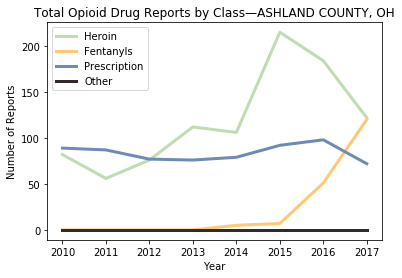

In [30]:
#def MakeStackplot(state,fips):
#    d = drugsbydata.groupby(["Year","State","FIPS"]).sum().unstack("Year").loc[(state,fips)]
#    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017],d[["Heroin","Fentanyl","Prescription","Other"]].values.reshape(-1,4),  
                   
#    plt.legend(["Heroin","Fentanyls","Prescription","Other"], 
#loc='upper left')
#    plt.title(label=fips+state)
#plt.show()
 
def MakeLinePlot(state,fips):
    d = drugsbydata.groupby(["Year","State","FIPS"]).sum().unstack("Year").loc[(state,fips)]
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017],d["Heroin"],label="Heroin",color="#c1dbb3",linewidth=3)
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017],d["Fentanyl"],label="Fentanyls",color="#ffc971",linewidth=3)
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017],d["Prescription"],label="Prescription",color="#6F8AB7",linewidth=3)
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017],d["Other"],label="Other",color="#32292F",linewidth=3)
    
    plt.legend(["Heroin","Fentanyls","Prescription","Other"])
    name = drugsbydata.groupby(["State","FIPS"]).apply(lambda x: x["Name"].astype(str)).drop_duplicates().loc[(state,fips)].values
    plt.title("Total Opioid Drug Reports by Class\u2014"+name[0]+' COUNTY, '+state)
    filename = state+'_'+name[0]+'CountyTotalReports'
    plt.xlabel("Year")
    plt.ylabel("Number of Reports")
    plt.savefig(filename+'.png', bbox_inches='tight')
    #plt.clf()
    plt.show()

MakeLinePlot('OH','005')

In [1]:
#Make lots O Line Plots
def LotsOLinePlots():
    for state,_ in drugsbydata.groupby(["State","FIPS"]).sum().iterrows():
        try:
            MakeLinePlot(state[0],state[1])
            time.sleep(0.05)
        except:
            pass
    
#LotsOLinePlots()
        

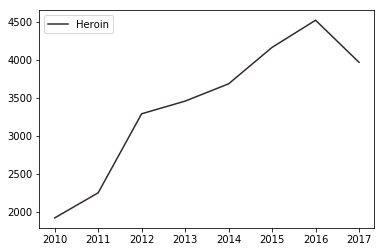

In [69]:
#d = drugsbydata.groupby(["State","FIPS","Year"]).sum().index.droplevel("Year")
d = drugsbydata.groupby(["Year","State","FIPS"]).sum().unstack("Year").loc[("OH","061")]
plt.plot([2010,2011,2012,2013,2014,2015,2016,2017],d["Heroin"], 
            label="Heroin", 
            color="#32292F" )
plt.legend(loc='upper left')
plt.show()

In [ ]:
drugsbydata.groupby(["Year","State","FIPS"]).sum().unstack("Year")["Heroin"].loc[("KY","015")]


In [ ]:
WestV = os.path.join('data', 'WV-54-west-virginia-counties.json')


WV = folium.Map(
    location=[38.678190, -80.716949],
    zoom_start=7,
    tiles='cartodbdark_matter'
)

#folium.TopoJson(
#    open(WestV),
#    'objects.cb_2015_west_virginia_county_20m',
#    name='WVjson'
#).add_to(WV)
#folium.LayerControl().add_to(P)

folium.Choropleth(
    open(WestV),
    topojson='objects.cb_2015_west_virginia_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='#f29d9d',
    line_color='#f0dede',
    line_weight=2,
    fill_opacity=0.3,
    highlight=True
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(WV)

WV

In [ ]:
Ohio = os.path.join('data', 'OH-39-ohio-counties.json')


O = folium.Map(
    location=[40.218927, -82.762618],
    zoom_start=7,
    tiles='OpenStreetMap'
)

folium.TopoJson(
    open(Ohio),
    'objects.cb_2015_ohio_county_20m',
    name='Ojson'
).add_to(O)
#folium.LayerControl().add_to(P)
O

In [ ]:
drug_data["DrugReports"].columns

In [ ]:
 # basic sankey chart
Sankey(flows=[0.25, 0.15, 0.60, -0.20, -0.15, -0.05, -0.50, -0.10], labels=['', '', '', 'First', 'Second', 'Third', 'Fourth', 'Fifth'], orientations=[-1, 1, 0, 1, 1, 1, 0,-1]).finish()
plt.title("Sankey diagram with default settings")

In [ ]:
%matplotlib inline
df=pd.DataFrame({'x': range(1,11), 'y': np.random.randn(10) })
plt.plot( 'x', 'y', data=df, color='skyblue')
plt.show()